### This notebook contains a step-by-step guide of how to do CRAB data analysis using the raw data from HDFS in the SWAN environment. It also provides ready-to-use functions to make data analysis more convenient.

## Table of content
1. [Import](#1-Import)
2. [Read raw data from HDFS using PySpark](#2-Read-raw-data-from-HDFS-using-PySpark)
    * (2.1)[Define the default HDFS folder](#2.1-Define-the-default-HDFS-folder)
    * (2.2)[Define the data structure](#2.2-Define-the-data-structure-needed)
    * (2.3)[Get the candidate files](#2.3-Get-the-candidate-files-that-contains-the-date-needed)
    * (2.4)[Spark dataframe](#2.4-Read-raw-data-to-spark-dataframe)
3. [Query](#3-Query)
4. [Collect row data from Spark dataframe](#4-Collect-row-data-from-Spark-dataframe)
5. [Ready-to-use functions](#5-Ready-to-use-functions)
     * (5.1) [Labels with percentage](#5.1-Labels-with-percentage)
     * (5.2) [Donut with arrow labels](#5.2-Donut-with-arrow-labels)
     * (5.3) [Multiple donuts](#5.3-Multiple-donuts)
     * (5.4) [Lines Graph with Mean Values](#5.4-Lines-Graph-with-Mean-Values)
     * (5.5) [Table](#5.5-Table)
    
    

## 1 Import

In [63]:
import time
from datetime import datetime, date, timedelta

import click
import numpy as np
import pandas as pd
from pandas.plotting import table
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    count as _count,
    first,
    date_format,
    from_unixtime
)
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
import matplotlib.pyplot as plt
from matplotlib import cm
from statistics import mean
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## 2 Read raw data from HDFS using PySpark

### 2.1 Define the default HDFS folder

In [ ]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"

### 2.2 Define the data structure needed

In [ ]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("CMSSite", StringType(), nullable=True),
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("OverflowType", StringType(), nullable=True),
                        StructField("WallClockHr", DoubleType(), nullable=True),
                        StructField("CoreHr", DoubleType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("ExitCode", LongType(), nullable=True),
                        StructField("Chirp_CRAB3_Job_ExitCode", LongType(), nullable=True),
                        StructField("Chirp_WMCore_cmsRun_ExitCode", LongType(), nullable=True),
                        StructField("JobExitCode", LongType(), nullable=True)
                    ]
                ),
            ),
        ]
    )

In [ ]:
schema = _get_schema()

### 2.3 Get the candidate files that contains the date needed

This function returns the candidate files by looking at a 7-days timespan (3 days before the specified date, current date, and 3 days after)

Reference: https://github.com/dmwm/CMSSpark/blob/cd1a4725601a3c3679f27b7439aa34d16f1442a2/src/python/CMSSpark/condor_cpu_efficiency.py#L138

In [ ]:
def get_candidate_files(
    start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER,
):
    """
    Returns a list of hdfs folders that can contain data for the given dates.
    """
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    #what is pre_candidate_files for????
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    # The candidate files are the folders to the specific dates,
    # but if we are looking at recent days the compaction procedure could
    # have not run yet so we will considerate also the .tmp folders.
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files

In [ ]:
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 2)
get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER)

### 2.4 Read raw data to spark dataframe

Modify the filter to suit your purpose

In [ ]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        ).select("data.*")
        .filter(
            f"""Status IN ('Completed', 'Removed', 'Held', 'Error') 
          AND RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )

spark.conf.set("spark.sql.session.timeZone", "UTC")

In [ ]:
raw_df.printSchema()

## 3 Query

### 3.1 PySpark SQL

pyspark.sql complete document: [https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html]

In [ ]:
df1 = raw_df.groupby([col("CMSPrimaryDataTier")])\
            .agg(_sum("WallClockHr").alias("sumWallClockHr"))\
            .sort("sumWallClockHr")

### 3.2 Traditional SQL

- convert the raw dataframe into a temporay view

In [ ]:
raw_df.CreateOrReplaceTempView('rawData')

- write the sql query

In [ ]:
df1 = spark.sql("SELECT data['CMSPrimaryDataTier'] AS CMSPrimaryDataTier,\
                        SUM(data['WallClockHr']) AS sumWallClockHr\
                 FROM rawData\
                 GROUP BY data['CMSPrimaryDataTier']\
                 ORDER BY SUM(data['WallClockHr'])")

## 4 Collect row data from Spark dataframe

In [ ]:
index = [(row['CMSPrimaryDataTier']) for row in df1.select('CMSPrimaryDataTier').collect()]
data = [(row['sumWallClockHr']) for row in df1.select('sumWallClockHr').collect()]

## 5 Ready-to-use functions

### 5.1 Labels with percentage

In [117]:
def _better_label(index, data):
    labels = []
    for i in range(len(index)):
        percent = data[i]*100/sum(data)
        labels.append(index[i]+": %.3f"%percent+"%")
    return labels

In [118]:
index = ["cat", "dog", "bird"]
data = [45, 454, 90]
label = _better_label(index, data)
label

['cat: 7.640%', 'dog: 77.080%', 'bird: 15.280%']

### 5.2 Donut with arrow labels

- startangle=0 : starts plotting the first label at 0degree then continue counter-clockwise
- arrowstyle="-" : other styles "->", "<->"
- figsize=(10, 10) : change the figure size

In [80]:
def _donut(data, labels, title):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=90)
    ax.set_title(title, y=1.08, fontsize=15)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
#     plt.savefig('final-avg-cpueff-onsite-offsite.png')
    plt.show()

Example: 

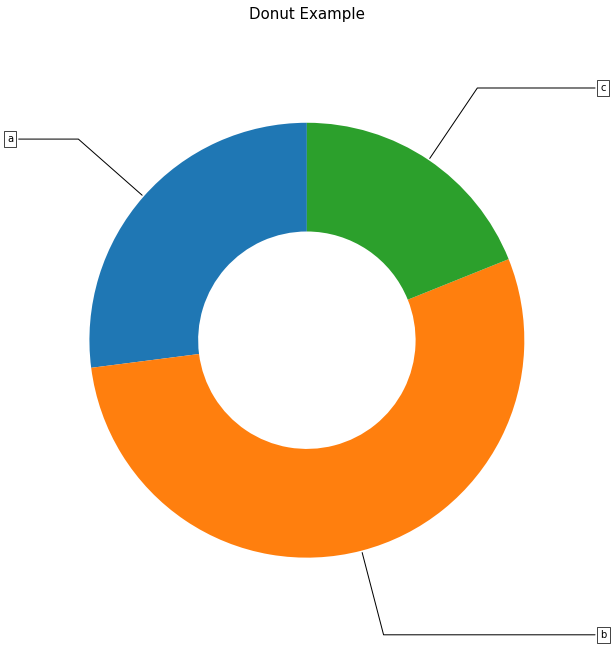

In [81]:
data = [10,20,7]
labels = ["a", "b", "c"]
title = "Donut Example"
_donut(data, labels, title)

### 5.3 Multiple donuts

- plt.subplots_adjust: adjust the position of the figure

In [83]:
def _multiple_donuts(data0, labels0, title0, data1, labels1, title1):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10, 10), subplot_kw=dict(aspect="equal"))
    
    wedges0, texts0 = ax[0].pie(data0, wedgeprops=dict(width=0.5), startangle=90)
    ax[0].set_title(title0, y=1.08, fontsize=15)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
     
    wedges1, texts1 = ax[1].pie(data1, wedgeprops=dict(width=0.5), startangle=90)
    ax[1].set_title(title1, y=1.08, fontsize=15)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges0):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax[0].annotate(labels0[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    for i, p in enumerate(wedges1):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax[1].annotate(labels1[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        
        
    plt.subplots_adjust(left=0.5,
                        bottom=0.1, 
                        right=2, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
#     plt.savefig('final-avg-cpueff-onsite-offsite.png')
    plt.show()

Example: 

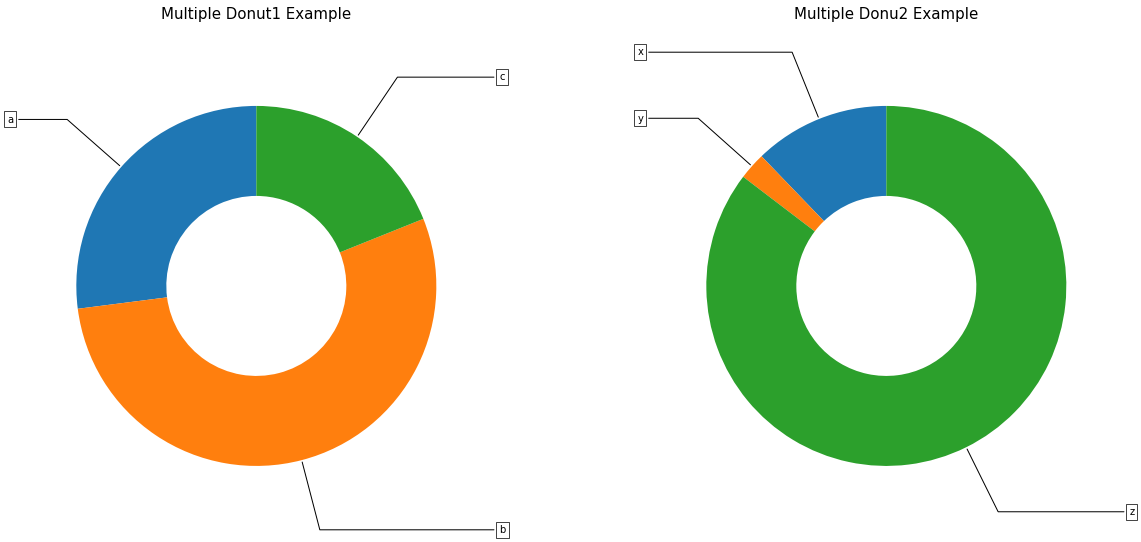

In [84]:
data = [10,20,7]
labels = ["a", "b", "c"]
title = "Multiple Donut1 Example"
data1 = [100,20,700]
labels1 = ["x", "y", "z"]
title1 = "Multiple Donu2 Example"
_multiple_donuts(data, labels, title,data1, labels1, title1)

### 5.4 Lines Graph with Mean Values

- plt.hlines() : linestyles = {'solid', 'dashed', 'dashdot', 'dotted'}
- **dataLabels : in case you want to label the lines

In [111]:
def _lines_graph(x, data0, data1, xlabel, ylabel, title, **dataLabels):
    fig, ax = plt.subplots(figsize=(10, 10))
    if(dataLabels):
        ax.plot(x, data0, color="blue", label=dataLabels['dataLabel_0'])
        ax.plot(x, data1, color="orange", label=dataLabels['dataLabel_1'])
    else:
        ax.plot(x, data0, color="blue")
        ax.plot(x, data1, color="orange")
    
    plt.hlines(mean(data0), 0,10, linestyles ="dotted", colors ="blue")
    plt.hlines(mean(data1), 0,10, linestyles ="dashed", colors ="orange")
    ax.text(4,mean(data0),'%f' % (mean(data0)))
    ax.text(4,mean(data1),'%f' % (mean(data1)))

    ax.set(xlabel=xlabel, ylabel=ylabel,
           title=title)
    ax.grid()
    plt.legend()
#     plt.savefig('final-avg-cpueff-onsite-offsite.png')
    plt.show()

Example:

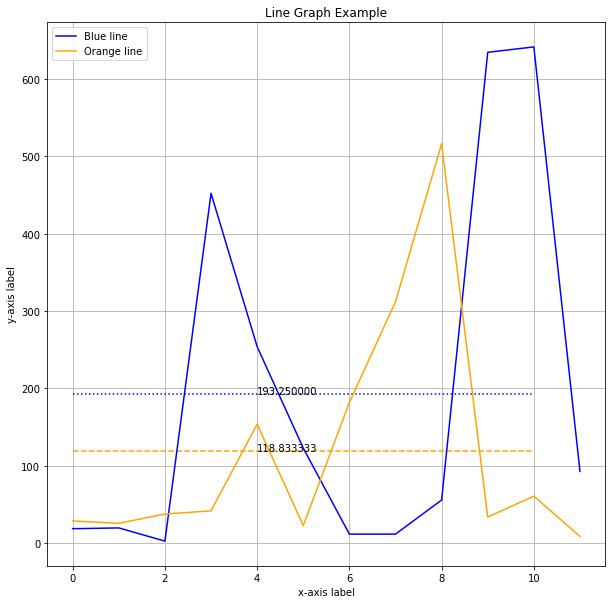

In [112]:
x = np.arange(0, 12, 1)
y1 = [19,20,3,452,254,123,12,12,56,634,641,93]
y2 = [29,26,38,42,154,23,182,312,516,34,61,9]
title = "Line Graph Example"
_lines_graph(x,y1,y2, "x-axis label", "y-axis label",title ,dataLabel_0="Blue line",dataLabel_1="Orange line" )
# _lines_graph(x,y1,y2, "x-axis label", "y-axis label",title )

### 5.5 Table

In [76]:
def _table(pandasDataframe):
    plt.figure(figsize=(10, 4))
    ax = plt.subplot() 
    plt.axis('off')
    tbl = table(ax,pandasDataframe, loc='center')
    tbl.auto_set_font_size(True)

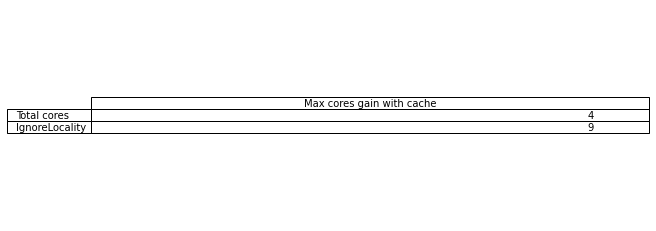

In [77]:
cpu_gain_table = pd.DataFrame({'Max cores gain with cache': [4, 9]},
                               index=["Total cores", "IgnoreLocality"])   
_table(cpu_gain_table)